In [1]:
import requests
import shutil
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

# Getting training data

We get our data to train our model from the [GTSRB](https://benchmark.ini.rub.de/gtsrb_dataset.html)
(German Traffic Sign Recognition Benchmark).

First, let's define some variables we will need later on.

In [2]:
data_dir = '../data/'
if not os.path.exists(data_dir):
        os.makedirs(data_dir)

zip_dir = '../data/GTSRB_Final_Training_Images.zip'
train_dir = '../data/train/'
image_dir = train_dir + 'GTSRB/Final_Training/Images/'
validation_dir = '../data/validation/'

Unpacking and extracting the GTSRB dataset.

In [4]:
url = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip'
response = requests.get(url)

with open(zip_dir, 'wb') as file:
    file.write(response.content)

shutil.unpack_archive(zip_dir, train_dir)
os.remove(zip_dir)

# Inspecting the data
Now we are going to take a look around the data to get familiar with the dataset itself.
## Class skew
First, let's look at how the data is distributed across our different classes.

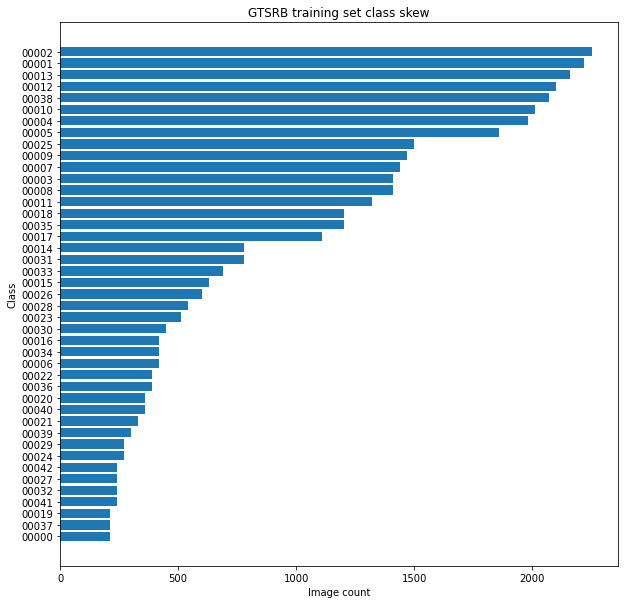

In [5]:
folders = (folder for folder in os.listdir(image_dir) if folder != '.DS_Store')

image_counts = []
for folder in folders:
    # Each directory also has a csv file - we exclude this as we are only interested in the number of pictures at the moment
    images = [image for image in os.listdir(os.path.join(image_dir, folder)) if image.endswith('.ppm')]
    image_counts.append((folder, len(images)))

image_counts.sort(key=lambda tup:tup[1])

classes = [x[0] for x in image_counts]
image_count = [x[1] for x in image_counts]

plt.subplots(figsize=(10, 10))
plt.barh(classes, image_count)
plt.title('GTSRB training set class skew')
plt.ylabel('Class')
plt.xlabel('Image count')
plt.show()

As we can see, there are a lot more pictures in class 00002 (which would be a speed limit 50 sign) than for example in
class 00037 (turn ahead or left).
Skewed classes can be a problem, because our model gets to see a lot more pictures of certain classes than of others
when training later on.

As far as I know this can be mitigated by using certain error functions, but for now we will pretend like we never heard
of this before.

## Label map
While the plot above shows us how many pictures we have for each class, it doesn't tell us which classes those numbers
actually are. To make these class names human-readable, let's introduce a label map.

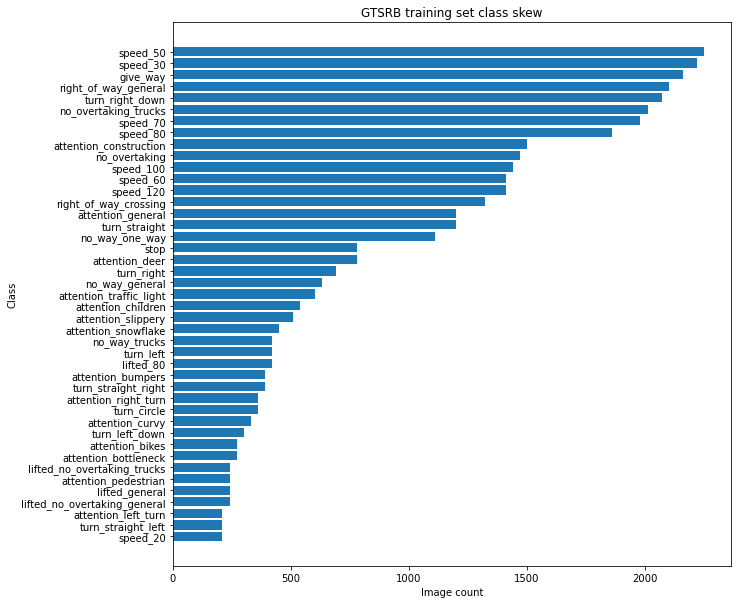

In [6]:
label_map = {
    0: 'speed_20',
    1: 'speed_30',
    2: 'speed_50',
    3: 'speed_60',
    4: 'speed_70',
    5: 'speed_80',
    6: 'lifted_80',
    7: 'speed_100',
    8: 'speed_120',
    9: 'no_overtaking',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

image_count = [x[1] for x in image_counts]
classes = [x[0] for x in image_counts]
class_labels = []

for cls in classes:
    class_labels.append(label_map[int(cls)])

plt.subplots(figsize=(10, 10))
plt.barh(class_labels, image_count)
plt.title('GTSRB training set class skew')
plt.ylabel('Class')
plt.xlabel('Image count')
plt.show()

Now it's much easier to read the diagram. If you've ever driven in Germany, you can probably confirm
that there are a quite a bit more signs limiting the speed to 50 km/h than signs limiting the speed to 20 km/h.

## Sample pictures
Let's plot some sample pictures of each class, so we roughly know with what kind of data or pictures we are dealing with.

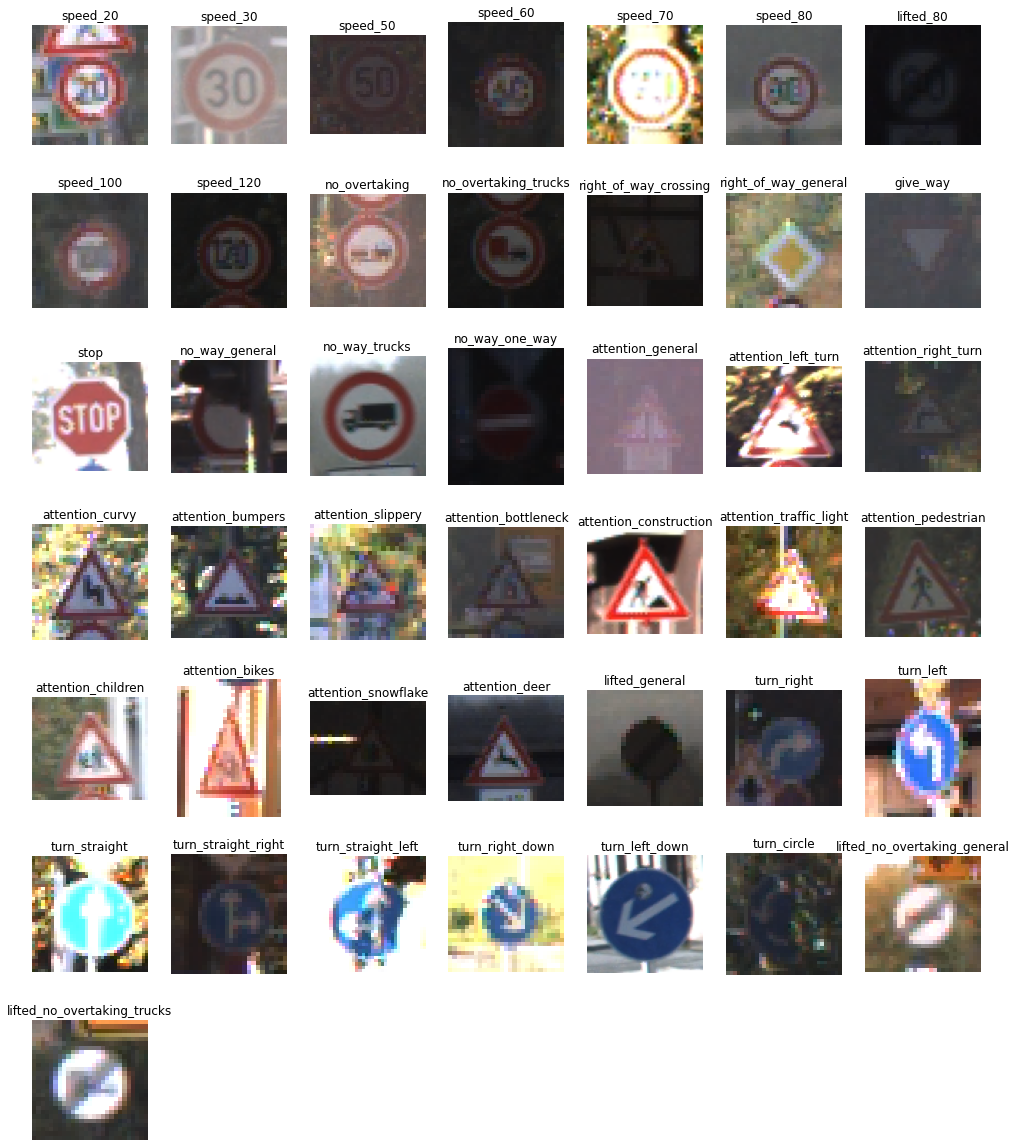

In [7]:
folders = (folder for folder in os.listdir(image_dir) if folder != '.DS_Store')
pictures_to_plot = []

for folder in folders:
    # Always get the first picture in the folder
    first_image_path = os.path.join(image_dir, folder, '00000_00000.ppm')
    pictures_to_plot.append((folder, first_image_path))

pictures_to_plot.sort(key=lambda tup:tup[1])

i = 0
plt.figure(figsize=(17, 30))
for image in pictures_to_plot:
    plt.subplot(10,7, i + 1)
    plt.axis('off')
    plt.title("{}".format(label_map[int(image[0])]))
    i += 1
    plt.imshow(Image.open(image[1]))
plt.show()

# Dataset preparation
Now that we know what data we are dealing with, it's time to prepare the data to train our machine learning model
later on.
This involves converting the pictures from ppm to jpg, as well as splitting the dataset into two subsets -
training and validation.

The training dataset will be used to train our model, and the validation dataset will be used to validate the training.
Don't confuse this with the actual testing of our model, this will be done at a later step.

## Converting to JPG
Let's start with converting our images to JPG. As they are currently .ppm files, TensorFlow will not be able to read them.
While we are at it, we are also moving the pictures into a directory that makes a bit more sense.

In [8]:
image_folders = (folder for folder in os.listdir(image_dir) if folder != '.DS_Store')

for folder in image_folders:
    images = os.listdir(os.path.join(image_dir, folder))
    for image_name in images:
        if image_name.endswith('.ppm'):
            image_path = os.path.join(image_dir, folder, image_name)
            image = Image.open(image_path)
            os.remove(image_path)
            new_dir = os.path.join(train_dir, folder)
            if not os.path.exists(new_dir):
                os.makedirs(new_dir)
            image_path = os.path.join(new_dir, image_name.split('.')[0] + '.jpg')
            image.save(image_path)

shutil.rmtree(os.path.join(train_dir, 'GTSRB'), ignore_errors=True)

## Dataset split
Now that our pictures are converted to JPG, lets split them into a training- and a validation-dataset.
This validation dataset will be used to validate the training process. This can be confused with the test-dataset,
which is a completely independent set of data used to test the model on unknown data later on.

This moves 20% of the pictures in a new 'validation'-folder, which contains a subfoler for each class. To make sure
we have some validation data for each class, I do this folder-by-folder instead of using a list of all images.


NOTE: I realize now that this could be done when fitting the data to our model, but I didn't realize that when first
writing the code. Since it doesn't really hurt anything (at least I THINK so), let's leave it in.

In [9]:
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

train_folders = (folder for folder in os.listdir(train_dir) if folder != '.DS_Store' and folder != 'GTSRB')
for train_folder in train_folders:
    validation_folder = os.path.join(validation_dir + train_folder)
    if not os.path.exists(validation_folder):
        os.makedirs(validation_folder)
    all_images = os.listdir(os.path.join(train_dir, train_folder))
    validation_images = random.sample(all_images, int(len(all_images) / 100 * 20))
    for validation_image in validation_images:
        full_old_path = os.path.join(train_dir, train_folder, validation_image)
        full_new_path = os.path.join(validation_folder, validation_image)
        os.replace(full_old_path, full_new_path)

# Model preparation
Now that we have prepared our datasets, we can get everything ready we need to actually train our model. We will be
using a pre-trained model, and then further train it with our own data.

For this we will be using Google's MobileNet V2 model, trained on the ImageNet dataset. To be honest, I only chose
this one because it seems to be one of the most-used ones, let's see how it goes ;)

## Image generators
First we need so-called ImageDataGenerators. These are basically used to generate batches of images. If we wanted to, we
could add data-augmentation here as well, such as zoom or rotation.

The image shape tuple defines, how large each picture should be (in pixels). This is needed, because our pre-trained
model has a specific input requirement/shape (224, 224, 3).
The first two values describe the size of the images, while the third one defines the color mode. 3 would be R/G/B,
while 1 would be grayscale for example.

Based on the ImageDataGenerator we create two generators for our datasets we divided earlier, basically telling it where
to find the data/pictures.

In [10]:
image_shape = (224, 224)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_data = image_generator.flow_from_directory(str(train_dir), target_size=image_shape)
validation_data = image_generator.flow_from_directory(str(validation_dir), target_size=image_shape)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


Now let's download the already mentioned model and turn it into a Keras layer we can use in our model later on. We also
freeze it's features, so our training only affects our own layer we add later.

In [11]:
feature_extractor_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))
feature_extractor_layer.trainable = False

We have everything we need to build our model, so let's do so.

A sequential model is a stack of layers, where each image gets processed through each layer sequentially.

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(train_data.num_classes)
])
model.summary()

# Start training
Now we finally have everything ready to actually start training our model.

First, we need to compile our model. When compiling, we tell the model which losses and metrics should be used.

Without going into too much detail, here is the rough definition of those parameters (from what I know and understand):
## Optimizers
Optimizers are mathematical functions, which define how each feature in our model should be optimized. This calculation
is performed after each batch that is being processed.
## Loss
Loss functions calculate the difference between actual values (e.g. a traffic sign says "speed limit 20" and the values
that our model predicted.
## Metrics
Metrics are functions used to judge the performance of a model. Performance doesn't mean how fast it is, but rather how
accurately it can predict values.

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

This is a class, which just collects the losses and accuracy after each batch, so we can take a look at them later
and see how they developed over time.

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

Now let's finally train our model. We provide it with our training- and validation-datasets, tell it how many epochs
we want to run and also provide our callback-class to collect the metrics we want. Based on the hardware used, this can
take quite some time.

In [16]:
batch_stats_callback = CollectBatchStats()

history = model.fit(train_data,
                    validation_data=validation_data,
                    epochs=20,
                    callbacks=[batch_stats_callback])

Epoch 1/20
981/981 [==============================] - 396s 403ms/step - loss: 0.2067 - acc: 0.9062 - val_loss: 0.3976 - val_acc: 0.8723